In [27]:
import os
from math import ceil 
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from scipy.spatial import distance
from geopy.geocoders import Nominatim # converts an address into latitude and longitude values
from scipy.ndimage.filters import gaussian_filter1d
from sklearn import preprocessing
from sklearn.decomposition import PCA
import folium

# Suburb Cluster Analysis
Load files

In [39]:
aus_suburbs = pd.read_csv(os.path.join('aus_suburbs.csv'), index_col=0)
venues_grouped = pd.read_csv(os.path.join('venues_grouped.csv'), index_col=0)
venues_sorted = pd.read_csv(os.path.join('venues_sorted.csv'), index_col=0)
ABS_data = pd.read_csv(os.path.join('ABS_2016_data.csv'), index_col=0)

# User input
First we need the users input.

In [29]:
input_suburb = {'Suburb':'South Yarra', 'City':'Melbourne'}

input_city = 'Sydney'

print('Your ideal suburb is:')
print('')
print('* {}, {}'.format(input_suburb['Suburb'], input_suburb['City']))
print('')
print('And you would like to find similar suburbs in {}.'.format(input_city))

Your ideal suburb is:

* South Yarra, Melbourne

And you would like to find similar suburbs in Sydney.


# Get data

Transform data to a normal distribution with yeo-johnson transformation because box-cox only works with positive numbers whereas yeo-johnson works with both negative and postive. Distance column contains 0km for distance to cbd for cbds.

In [90]:
# Extract data to be transformed and standardised
aus_suburbs_temp = aus_suburbs[['Suburb','area', 'density', 'distance']]

ABS_data_temp = ABS_data[['Suburb', 'State', 'Age_Median age','Rent weekly payments_Median rent']]

In [91]:
ABS_data_temp.rename({'Age_Median age':'median_age',
                    'Rent weekly payments_Median rent':'median_rent'}, axis=1, inplace=True)

In [92]:
# Fill missing median age
means = ABS_data_temp.groupby(['State'])['median_age'].mean()
ABS_data_temp = ABS_data_temp.set_index(['State'])
ABS_data_temp['median_age'] = ABS_data_temp['median_age'].fillna(means)
ABS_data_temp = ABS_data_temp.reset_index()

# Fill missing median rent
means = ABS_data_temp.groupby(['State'])['median_rent'].mean()
ABS_data_temp = ABS_data_temp.set_index(['State'])
ABS_data_temp['median_rent'] = ABS_data_temp['median_rent'].fillna(means)
ABS_data_temp = ABS_data_temp.reset_index()
# Round off rent
ABS_data_temp['median_rent'] = ABS_data_temp.median_rent.map(lambda x: round(x,1))

#Drop columns
columns = ['State', 'Suburb']
ABS_data_temp.drop(columns, inplace=True, axis=1)

In [93]:
# Concatenate dataframes
temp_data = pd.concat([aus_suburbs_temp, ABS_data_temp], axis=1, sort=False)

In [95]:
temp_data.dropna(subset=['median_age', 'median_rent'], inplace=True)

# Geographic Analysis

In [169]:
# Transform data
geographic_df = temp_data[['area', 'distance']]
geographic_df['area'] = np.log(geographic_data['area'])
geographic_df['distance'] = np.sqrt(geographic_data['distance'])

# Add suburb and postcode labels to rows
geographic_df.insert(0, 'Suburb_id', aus_suburbs.Suburb_id)
geographic_df.insert(1, 'Suburb', aus_suburbs.Suburb)
geographic_df.insert(2, 'Postcode', aus_suburbs.Postcode)
geographic_df.insert(3, 'LGA', aus_suburbs.LGA)
geographic_df.insert(4, 'City', aus_suburbs.City)

/Users/Jason/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Jason/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Distance from CBD')

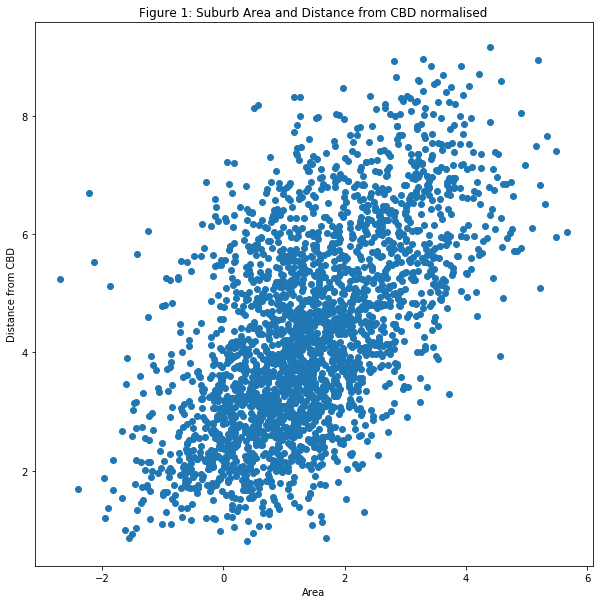

In [170]:
plt.figure(figsize=(10,10))
plt.scatter(geographic_data.area, geographic_data.distance)
plt.title('Figure 1: Suburb Area and Distance from CBD normalised')
plt.xlabel('Area')
plt.ylabel('Distance from CBD')

# Geographic KNN

In [171]:
# Input data
input_suburb_df = geographic_df.loc[(geographic_df.Suburb == input_suburb['Suburb']) &
                              (geographic_df.City == input_suburb['City'])]
input_city_df = geographic_df.loc[geographic_df.City == input_city]

# Dataframe for pairwise calculation
knn_df = pd.concat([input_suburb_df, input_city_df], ignore_index=True)

# Convert dataframe to array
values_df = knn_df.drop(['Suburb_id', 'Suburb', 'City', 'Postcode', 'LGA'], axis=1)
values_array = values_df.values

# Pairwise calculation
D = distance.squareform(distance.pdist(values_array))
D = D[0]

# Convert pairwise distances to dataframe
knn_dist = pd.DataFrame(data=D.flatten())

# Add distances to full geographic dataframe
knn_df['knn_dist'] = knn_dist

# Inverse distances
knn_df['knn_dist_inverse'] = 1/knn_df['knn_dist']

# Normalise the inverse values between 0 and 1
# First drop user input row
knn_df.drop([0], inplace=True)
knn_df.reset_index(inplace=True, drop=True)
# Normalise pw_dist_inverse column
knn_normalised = knn_df['knn_dist_inverse']/ceil(max(knn_df['knn_dist_inverse']))
knn_df['knn_normalised'] = knn_normalised

Plot nearest neighbour results

In [173]:
# Get top 10 most similar suburbs in PCA dataframe
knn_df_sort = knn_df.sort_values(by=['knn_normalised'], ascending=False)
top_10 = knn_df_sort[:10]

In [175]:
knn_df_sort.head(10)

,Suburb_id,Suburb,Postcode,LGA,City,area,distance,knn_dist,knn_dist_inverse,knn_normalised
5,28,Alexandria,2015.0,City of Sydney,Sydney,1.234017,2.168411,0.096662,10.345277,0.940480
317,1221,Kensington,2033.0,City of Randwick,Sydney,0.949726,2.150595,0.352543,2.836537,0.257867
599,2323,Vaucluse,2030.0,"Waverley Council, Woollahra Council",Sydney,1.096276,2.428514,0.388955,2.570991,0.233726
350,1337,Leichhardt,2040.0,Inner West Council,Sydney,0.924259,2.259089,0.407798,2.452194,0.222927
522,1968,Rose Bay,2029.0,"Waverley Council, Municipality of Woollahra",Sydney,0.893227,2.292060,0.449781,2.223306,0.202119
46,192,Bellevue Hill,2023.0,Municipality of Woollahra,Sydney,0.837248,2.098626,0.460770,2.170282,0.197298
506,1899,Randwick,2031.0,City of Randwick,Sydney,1.653646,2.405024,0.471164,2.122403,0.192946
452,1709,Northbridge,2063.0,City of Willoughby,Sydney,0.973427,2.517760,0.532227,1.878897,0.170809
359,1351,Lilyfield,2040.0,Inner West Council,Sydney,0.762673,2.040775,0.538173,1.858137,0.168922
190,692,Drummoyne,2047.0,City of Canada Bay,Sydney,0.784814,2.312564,0.557032,1.795229,0.163203


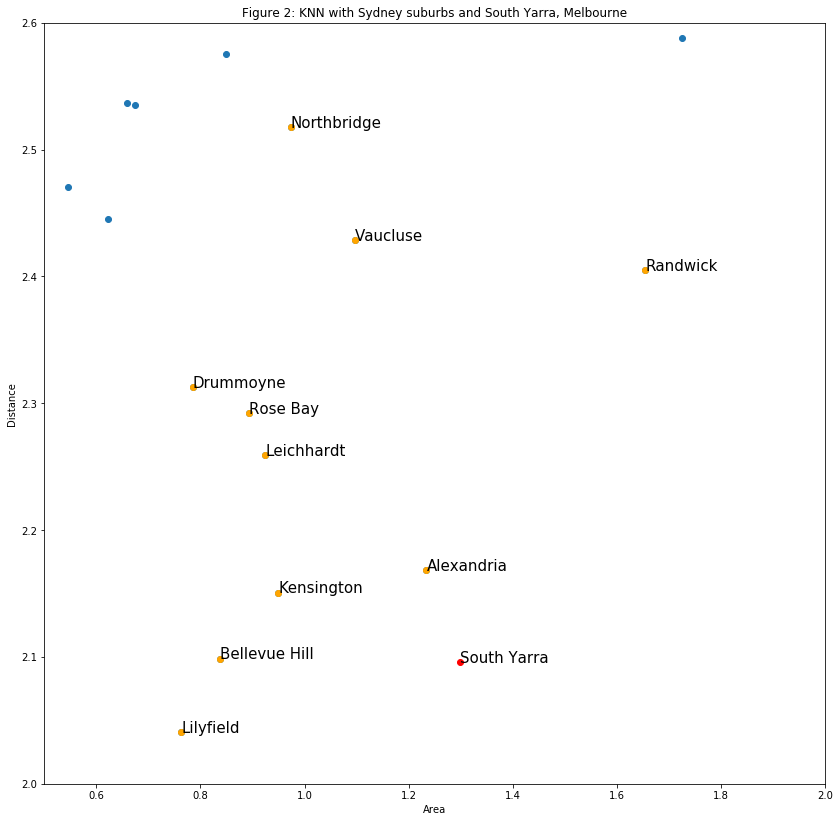

In [187]:
# Plot the knn of South Yarra, Melbourne
input_x = input_suburb_df.area.values[0]
input_y = input_suburb_df.distance.values[0]
plt.figure(figsize=(14,14))
plt.scatter(knn_df.area, knn_df.distance)
plt.scatter(top_10.area, top_10.distance, c='orange')
plt.scatter(input_x, input_y, c='red')
plt.title('Figure 2: KNN with Sydney suburbs and South Yarra, Melbourne')
plt.xlabel('Area')
plt.ylabel('Distance')
plt.xlim(0.5,2)
plt.ylim(2,2.6)
# Label input suburb
plt.annotate(input_suburb['Suburb'], (input_x, input_y), size=15)
# Label top 10 suburbs
for area, dist, txt in zip(top_10.area, top_10.distance, [*top_10.Suburb]):
    plt.annotate(txt, (area, dist), size=15)

# Demographic Analysis

In [113]:
# Extract area, density, and distance columns to be transformed and standardised
demographic_data = temp_data[['density', 'median_age', 'median_rent']]

# Yeo-Johnson transformation
# Create the Scaler object
scaler = preprocessing.PowerTransformer(method='yeo-johnson', standardize=False)

# Fit your data on the scaler object
yeojohnson = scaler.fit_transform(demographic_data)

suburbs_info_yeojohnson = pd.DataFrame(yeojohnson, columns=demographic_data.columns)

# Matrix standardisation
# Create the Scaler object
scaler = preprocessing.StandardScaler()

# Fit your data on the scaler object
standardised = scaler.fit_transform(yeojohnson)

standardised = pd.DataFrame(standardised, columns=demographic_data.columns)

# Add suburb and postcode labels to rows
demographic_df = standardised
demographic_df.insert(0, 'Suburb_id', aus_suburbs.Suburb_id)
demographic_df.insert(1, 'Suburb', aus_suburbs.Suburb)
demographic_df.insert(2, 'Postcode', aus_suburbs.Postcode)
demographic_df.insert(3, 'LGA', aus_suburbs.LGA)
demographic_df.insert(4, 'City', aus_suburbs.City)

# Demographic PCA

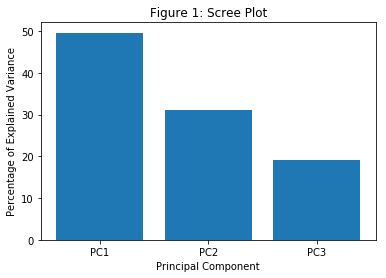

In [115]:
data = demographic_df.drop(columns=['Suburb_id', 'Suburb', 'Postcode', 'LGA', 'City'], axis=1)

pca = PCA()
pca.fit(data)
pca_data = pca.transform(data)

percentage_variation = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(percentage_variation)+1)]

plt.bar(x=range(1,len(percentage_variation)+1), height=percentage_variation, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Figure 1: Scree Plot')
plt.show()

In [116]:
print('PC1: {}'.format(pca.explained_variance_ratio_[0]))
print('PC2: {}'.format(pca.explained_variance_ratio_[1]))
print('PC3: {}'.format(pca.explained_variance_ratio_[2]))

PC1: 0.49621741770974226
PC2: 0.31241508431045034
PC3: 0.1913674979798074


In [102]:
0.4922169689424657+0.1925448182611165+0.17559283684564406

0.8603546240492262

PC1, PC2, and PC3 accounts for 86% of the total variation around the PCs.

(-5, 5)

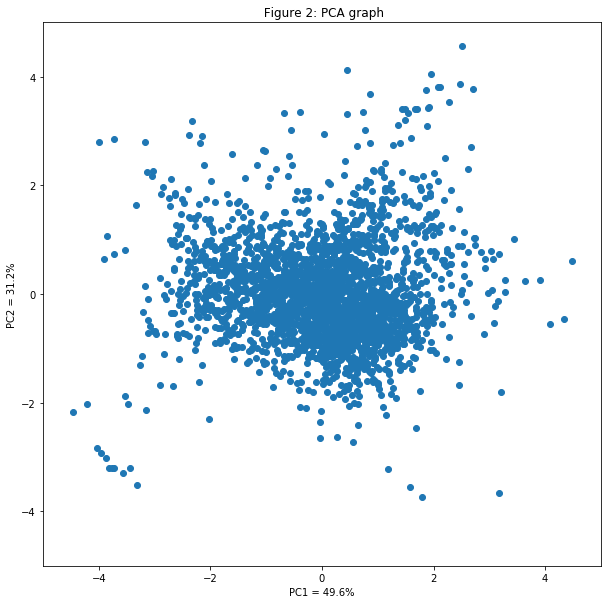

In [118]:
pca_df = pd.DataFrame(pca_data, columns=labels)

plt.figure(figsize=(10,10))
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title(' Figure 2: PCA graph')
plt.xlabel('PC1 = {}%'.format(percentage_variation[0]))
plt.ylabel('PC2 = {}%'.format(percentage_variation[1]))
plt.xlim(-5,5)
plt.ylim(-5,5)

Furthermore, appears that the list of suburbs can be roughly divided into two or three clusters. This will be further analysed in another notebook.

In [8]:
# The normalised variance of each attribute for all three principle components.
pd.DataFrame(pca.components_,columns=data.columns,index = ['PC1','PC2','PC3'])

,area,density,distance
PC1,-0.589922,0.582163,-0.559533
PC2,0.295095,-0.489582,-0.820505
PC3,-0.751605,-0.649150,0.117022


In addition to PC1 having the most variation in regards to suburb area, density, and distance, all three attribuates for PC1 had roughly an equal influence on the distribution of the data. However, suburb area and density had a slight larger influence.

In [119]:
# Add suburb and postcode labels to rows
demographic_df = pca_df
demographic_df.insert(0, 'Suburb_id', aus_suburbs.Suburb_id)
demographic_df.insert(1, 'Suburb', aus_suburbs.Suburb)
demographic_df.insert(2, 'Postcode', aus_suburbs.Postcode)
demographic_df.insert(3, 'LGA', aus_suburbs.LGA)
demographic_df.insert(4, 'City', aus_suburbs.City)

# Drop PC3 column
demographic_df.drop(columns='PC3', axis=1, inplace=True)

# Demographic KNN

#### 3. K Nearest Neighbour

Here I implement **KNN pairwise by distance** to find the most similar suburbs from the user input in regards to population density, suburb size, and  distance from cbd. I will implement KNN with the PCA transformed data.

In [10]:
# Input data
input_suburb_df = geo_df.loc[(geo_df.Suburb == input_suburb['Suburb']) &
                              (geo_df.City == input_suburb['City'])]
input_city_df = geo_df.loc[geo_df.City == input_city]

# Dataframe for pairwise calculation
knn_df = pd.concat([input_suburb_df, input_city_df], ignore_index=True)

# Convert dataframe to array
values_df = knn_df.drop(['Suburb_id', 'Suburb', 'City', 'Postcode', 'LGA'], axis=1)
values_array = values_df.values

# Pairwise calculation
D = distance.squareform(distance.pdist(values_array))
D = D[0]

# Convert pairwise distances to dataframe
knn_dist = pd.DataFrame(data=D.flatten())

# Add distances to full geographic dataframe
knn_df['knn_dist'] = knn_dist

# Inverse distances
knn_df['knn_dist_inverse'] = 1/knn_df['knn_dist']

# Normalise the inverse values between 0 and 1
# First drop user input row
knn_df.drop([0], inplace=True)
knn_df.reset_index(inplace=True, drop=True)
# Normalise pw_dist_inverse column
knn_normalised = knn_df['knn_dist_inverse']/ceil(max(knn_df['knn_dist_inverse']))
knn_df['knn_normalised'] = knn_normalised

#### 4. Plot user input and listed suburbs on PCA scatterplot

In [11]:
# Get top 10 most similar suburbs in PCA dataframe
knn_df_sort = knn_df.sort_values(by=['knn_normalised'], ascending=False)
top_10 = knn_df_sort[:10]

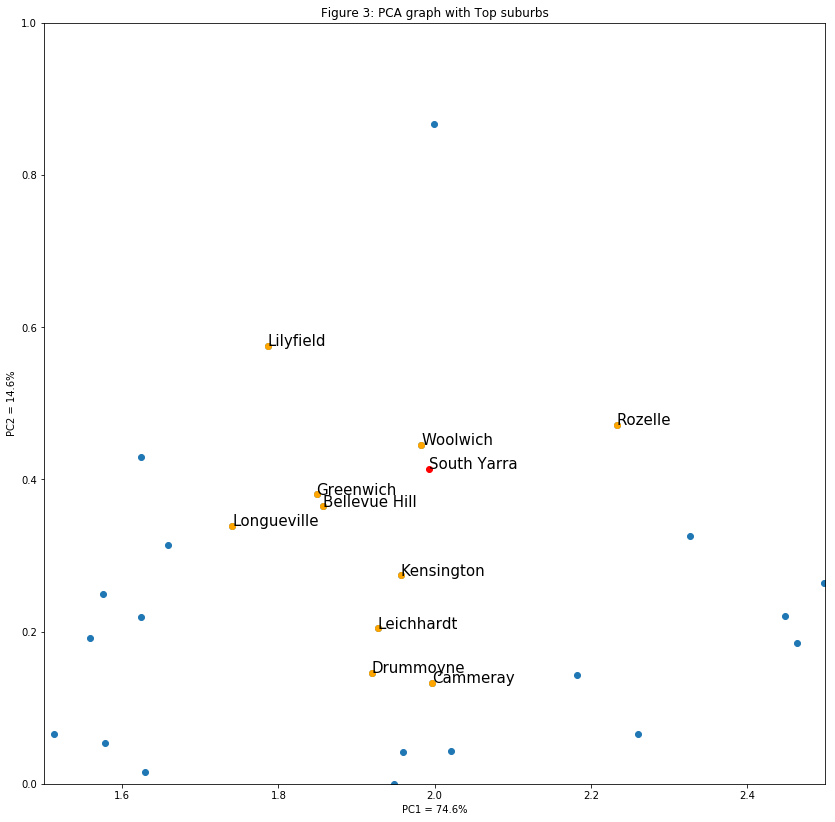

In [12]:
input_x = input_suburb_df.PC1.values[0]
input_y = input_suburb_df.PC2.values[0]
plt.figure(figsize=(14,14))
plt.scatter(knn_df.PC1, knn_df.PC2)
plt.scatter(top_10.PC1, top_10.PC2, c='orange')
plt.scatter(input_x, input_y, c='red')
plt.title('Figure 3: PCA graph with Top suburbs')
plt.xlabel('PC1 = {}%'.format(percentage_variation[0]))
plt.ylabel('PC2 = {}%'.format(percentage_variation[1]))
plt.xlim(1.5,2.5)
plt.ylim(0,1)
# Label input suburb
plt.annotate(input_suburb['Suburb'], (input_x, input_y), size=15)
# Label top 10 suburbs
for pc1, pc2, txt in zip(top_10.PC1, top_10.PC2, [*top_10.Suburb]):
    plt.annotate(txt, (pc1, pc2), size=15)

Get top ten most similar suburbs in Australian suburbs dataset.

In [13]:
# Add knn normalised values to new dataframe
top_ten_knn = aus_suburbs[['Suburb', 'Postcode', 'LGA', 'City', 'area', 'density', 'distance']]
top_ten_knn = top_ten_knn.loc[top_ten_knn.City == input_city]
top_ten_knn.reset_index(inplace=True, drop=True)

# top_ten_knn.reset_index(inplace=True, drop=True)
top_ten_knn['knn_normalised'] = knn_normalised

# Sort suburbs by their knn_normalised values in descending order.
top_ten_knn.sort_values(by=['knn_normalised'], ascending=False, inplace=True)
top_ten_knn.reset_index(inplace=True, drop=True)

# Get top 10 suburbs
top_ten_knn = top_ten_knn[:10]
top_ten_knn

,Suburb,Postcode,LGA,City,area,density,distance,knn_normalised
0,Woolwich,2110,Municipality of Hunter's Hill,Sydney,0.480,1695.833333,4.754440,0.985048
1,Kensington,2033,City of Randwick,Sydney,2.585,5804.255319,4.444528,0.223085
2,Bellevue Hill,2023,Municipality of Woollahra,Sydney,2.310,4638.961039,4.503572,0.222268
3,Greenwich,2065,Municipality of Lane Cove,Sydney,1.601,3505.933791,4.743348,0.217964
4,Leichhardt,2040,Inner West Council,Sydney,2.520,5803.571429,4.860991,0.146714
5,Rozelle,2039,Inner West Council,Sydney,1.723,5063.842136,3.138417,0.130479
6,Lilyfield,2040,Inner West Council,Sydney,2.144,3552.238806,3.956786,0.122956
7,Longueville,2066,Municipality of Lane Cove,Sydney,0.949,2170.706006,5.741948,0.122549
8,Drummoyne,2047,City of Canada Bay,Sydney,2.192,5451.642336,5.261509,0.116186
9,Cammeray,2062,North Sydney Council,Sydney,1.514,4627.476882,5.331783,0.114636


#### 5. Plot average area, density, and distance against the user inputs suburb in a bar chart

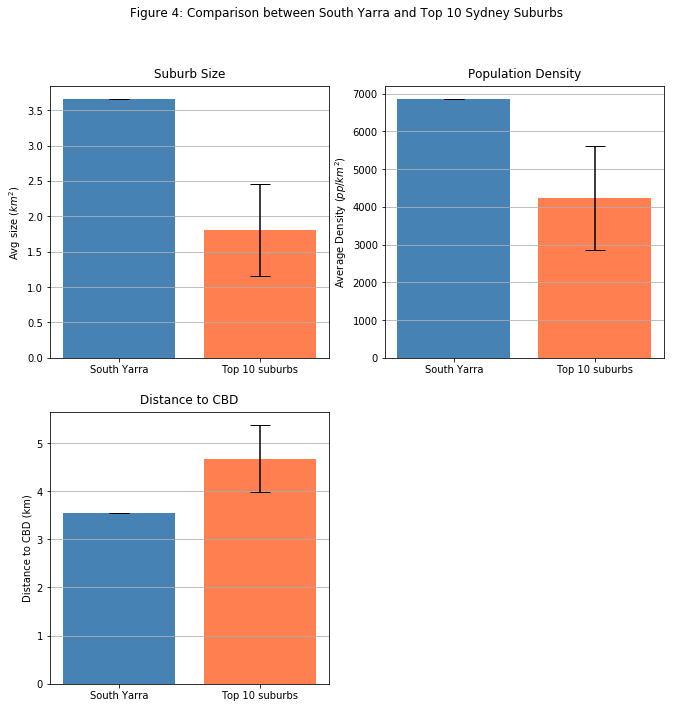

In [14]:
# Input data
input_index = aus_suburbs.loc[aus_suburbs.Suburb == input_suburb['Suburb']].index.values[0]
input_area = aus_suburbs.at[input_index, 'area']
input_density = aus_suburbs.at[input_index, 'density']
input_distance = aus_suburbs.at[input_index, 'distance']

# Calculate average
area_mean = np.mean(top_ten_knn.area.values)
density_mean = np.mean(top_ten_knn.density.values)
distance_mean = np.mean(top_ten_knn.distance.values)

# Calculate standard deviation
area_std = np.std(top_ten_knn.area.values)
density_std = np.std(top_ten_knn.density.values)
distance_std = np.std(top_ten_knn.distance.values)

# Subplot
# Create lists for the plot
mean_list = [area_mean,
             density_mean,
             distance_mean]
input_mean = [input_area,
              input_density,
              input_distance]
error_data = [area_std,
              density_std,
              distance_std]
chart_coordinates = [(0,0),
                     (0,1),
                     (1,0)]
y_labels = ['Avg size ($km^2$)',
            'Average Density ($pp/km^2$)',
            'Distance to CBD (km)']
titles = ['Suburb Size',
          'Population Density',
          'Distance to CBD']

category = [input_suburb['Suburb'],
            'Top 10 suburbs']
x_pos = np.arange(len(category))

# Build the plot
fig, ax = plt.subplots(2, 2, figsize=(11,11))
fig.suptitle('Figure 4: Comparison between South Yarra and Top 10 Sydney Suburbs')
for user_input, mean, error, coord, ylabel, title in zip(input_mean,
                                                         mean_list, 
                                                         error_data,
                                                         chart_coordinates,
                                                         y_labels,
                                                         titles):
    ax[coord].bar(x_pos,
                  [user_input, mean],
                  yerr=[0, error],
                  align='center',
                  alpha=1,
                  color=('steelblue', 'coral'),
                  capsize=10)
    ax[coord].set_ylabel(ylabel)
    ax[coord].set_xticks(x_pos)
    ax[coord].set_xticklabels(category)
    ax[coord].set_title(title, y=1.01)
    ax[coord].yaxis.grid(True)


# Delete empty axes
fig.delaxes(ax[1][1])
plt.show()

# Local venues - Dot Product

#### 1. Normalise data with MinMaxScaler

In [15]:
# Drop label columns to standardise hot-encoded columns
temp_data = venues_grouped.drop(['Suburb_id', 'Suburb', 'Postcode', 'LGA', 'City'], axis=1)

# Matrix standardisation
# Create the Scaler object
scaler = preprocessing.MinMaxScaler()

# Fit your data on the scaler object
standardised = scaler.fit_transform(temp_data)

standardised = pd.DataFrame(standardised, columns=temp_data.columns)


# Add suburb and postcode columns
venue_df = standardised
venue_df.insert(0, 'Suburb_id', venues_grouped.Suburb_id)
venue_df.insert(1, 'Suburb', venues_grouped.Suburb)
venue_df.insert(2, 'Postcode', venues_grouped.Postcode)
venue_df.insert(3, 'City', venues_grouped.City)

# venue_df = venues_grouped.drop(['LGA'], axis=1)

/Users/Jason/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


#### 2. Dot product
Here I implement **dot product valuation** to find the most similar suburbs in regard to its local venues.

In [16]:
# Input data
input_suburb_ven = venue_df.loc[(venue_df.Suburb == input_suburb['Suburb']) &
                                (venue_df.City == input_suburb['City'])]

input_city_ven = venue_df.loc[venue_df.City == input_city]

# Add input_suburb to city dataframe
dot_df = pd.concat([input_suburb_ven, input_city_ven], ignore_index=True)

# Convert dataframe to array
input_profile = input_suburb_ven.drop(['Suburb_id', 'Suburb', 'Postcode', 'City'], axis=1)
input_profile = input_profile.values
values_df = dot_df.drop(['Suburb_id', 'Suburb', 'Postcode', 'City'], axis=1)
values_array = values_df.values

# Dot product calculation
dot_product = (values_array).dot(input_profile[0])

# Convert dot product arrays to dataframe
dot_product_df = pd.DataFrame(data=dot_product.flatten())

# Add dot product values to full venues dataframe
dot_df['dot_product'] = dot_product_df

# Normalise the dot product between 0 and 1
# Drop user input row
dot_df.drop([0], inplace=True)
dot_df.reset_index(inplace=True, drop=True)
# Normalise dot_product column
dot_normalised = dot_df['dot_product']/ceil(max(dot_df['dot_product']))
dot_df['dot_normalised'] = dot_normalised

# Sort rows and get top 10 suburbs
dot_df.sort_values(by=['dot_normalised'], ascending=False, inplace=True)
dot_df.reset_index(inplace=True, drop=True)
top_ten_dot = dot_df[:10]

The top ten suburbs that have the most similar local venues to the input suburb

In [17]:
top_ten_dot[['Suburb_id', 'Suburb', 'Postcode', 'dot_product', 'dot_normalised']]

,Suburb_id,Suburb,Postcode,dot_product,dot_normalised
0,467,Parramatta,2150,4.926406,0.985281
1,634,Woolloomooloo,2011,4.734381,0.946876
2,565,Surry Hills,2010,4.420148,0.884030
3,163,Crows Nest,2065,4.077030,0.815406
4,155,Coogee,2034,3.728331,0.745666
5,578,The Rocks,2000,3.684622,0.736924
6,442,North Sydney,2060,3.096983,0.619397
7,31,Bankstown,2200,3.075751,0.615150
8,650,Norwest,2153,3.045499,0.609100
9,489,Pyrmont,2009,3.042416,0.608483


Show the top ten suburbs in regards to most similar venues and their venues ranked from the most to least common. User input row is included for comparison.

#### 3. Plot top 10 most common local venues for each suburb

In [18]:
top_venues = venues_sorted.drop(['Suburb_id', 'City'], axis=1)
top_venues = top_venues.iloc[top_ten_dot.Suburb_id.values]

# Add input suburb to compare its local venues
input_suburb_venue = venues_sorted.loc[(venues_sorted.Suburb == input_suburb['Suburb']) &
                                           (venues_sorted.City == input_suburb['City'])]

input_suburb_venue = input_suburb_venue.drop(['Suburb_id', 'City'], axis=1)
input_suburb_venue
top_venues = pd.concat([input_suburb_venue, top_venues], ignore_index=True)

top_venues

,Suburb,Postcode,LGA,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,South Yarra,3141,"City of Stonnington, City of Melbourne",Café,Italian Restaurant,Japanese Restaurant,Hotel,Convenience Store,Thai Restaurant,Bar,Grocery Store,Dessert Shop,French Restaurant
1,Parramatta,2150,City of Parramatta,Café,Thai Restaurant,Burger Joint,Chinese Restaurant,Mexican Restaurant,Dessert Shop,Juice Bar,Asian Restaurant,Japanese Restaurant,Italian Restaurant
2,Woolloomooloo,2011,City of Sydney,Café,Italian Restaurant,Hotel,Australian Restaurant,Thai Restaurant,Hostel,Chinese Restaurant,Pub,Bar,Restaurant
3,Surry Hills,2010,City of Sydney,Café,Pub,Pizza Place,Japanese Restaurant,Breakfast Spot,Lebanese Restaurant,Vietnamese Restaurant,Thai Restaurant,Karaoke Bar,Indian Restaurant
4,Crows Nest,2065,North Sydney Council,Café,Japanese Restaurant,Thai Restaurant,Vietnamese Restaurant,Italian Restaurant,Indian Restaurant,Bar,Sandwich Place,Mexican Restaurant,Asian Restaurant
5,Coogee,2034,City of Randwick,Café,Hotel,Burger Joint,Bar,Park,Thai Restaurant,Fish & Chips Shop,Indian Restaurant,Italian Restaurant,Sushi Restaurant
6,The Rocks,2000,City of Sydney,Café,Hotel,Australian Restaurant,Pub,Hotel Bar,Italian Restaurant,Steakhouse,Park,Cocktail Bar,Scenic Lookout
7,North Sydney,2060,North Sydney Council,Café,Gym,Japanese Restaurant,Bar,Juice Bar,Sandwich Place,Bakery,Vietnamese Restaurant,Plaza,Grocery Store
8,Bankstown,2200,Canterbury-Bankstown Council,Vietnamese Restaurant,Café,Convenience Store,Fast Food Restaurant,Sports Bar,Department Store,Steakhouse,Lebanese Restaurant,Gym,Grocery Store
9,Norwest,2153,The Hills Shire,Café,Sandwich Place,Hotel,Supermarket,Gym / Fitness Center,Mexican Restaurant,Pizza Place,Restaurant,Liquor Store,Train Station


#### 4. Plot the most common venues among the similar suburbs

In [19]:
# List all of the venues in the dataframe
venues = top_venues.drop(['Suburb', 'Postcode', 'LGA'], axis=1)
venues = pd.DataFrame(data=venues.values.flatten())
venues = venues.dropna()
venues.rename(columns={0: "Venues"}, inplace=True)

# Group dataframe by venue and show its frequency count
venues_count = venues.groupby(['Venues']).agg({'Venues' :'count'})
venues_count.rename(columns={'Venues': 'Venues', 'Venues': 'Frequency'}, inplace=True)
venues_count.sort_values(by=['Frequency'], inplace=True, ascending=False)


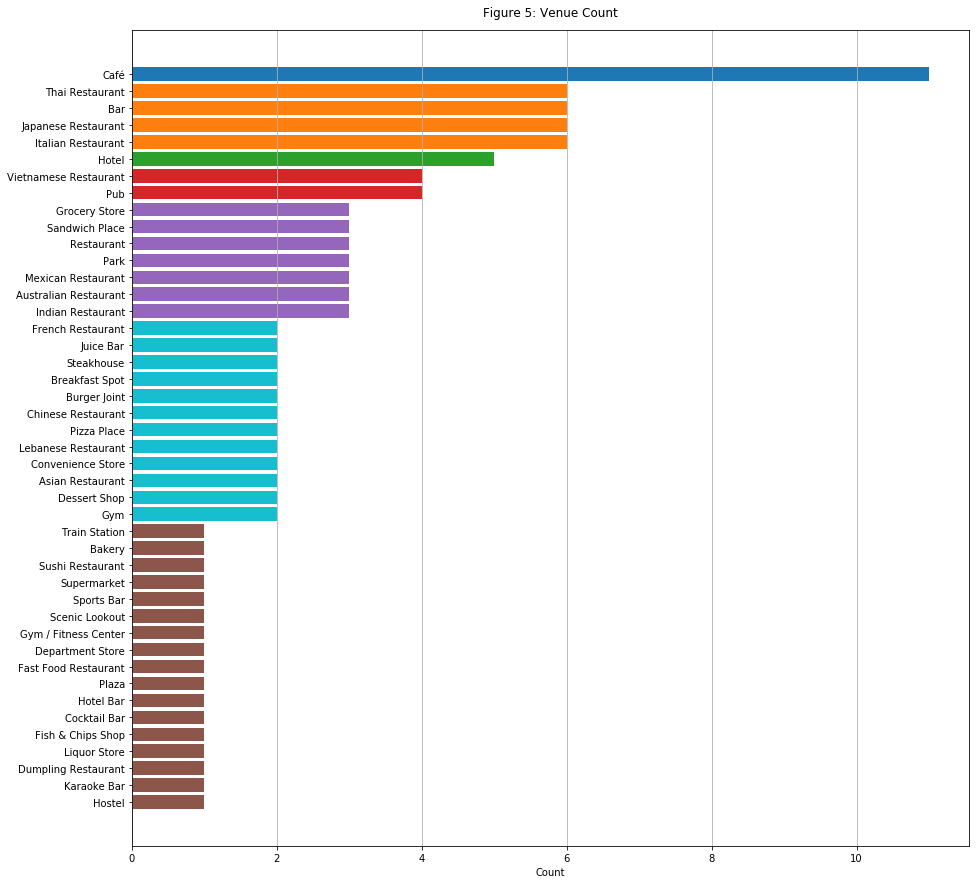

In [20]:
# Create lists for the plot
materials = venues_count.index
y_pos = np.arange(len(materials))
values = venues_count.values.flatten()

unique_values = list(np.unique(values))
unique_values.sort(reverse=True)

bar_colours = ['tab:blue',
               'tab:orange',
               'tab:green',
               'tab:red',
               'tab:purple',
               'tab:cyan',
               'tab:brown',
               'tab:pink',
               'tab:gray',
               'tab:olive']
bar_colours_range = bar_colours[0:len(unique_values)]

# Build the plot
fig = plt.figure(figsize=(15,15))
for val, colour in zip(unique_values, bar_colours_range):
    mask = values == val
    plt.barh(y_pos[mask], values[mask], color=colour, align='center')
plt.xlabel('Count')
plt.yticks(y_pos, materials)
plt.title('Figure 5: Venue Count', y=1.01)
plt.gca().invert_yaxis()
plt.grid(axis='x')

# Find the overall most similar suburb using Naive Bayes.

Here I combine the findings from above and implement Naive Bayes to find the most similar suburb.

Pior probability will be set to 0.5, which means both the geographic/demographic and local venues will have an equal contribution to the final probability value (posterior probability).

In [21]:
# Combine pairwise distances and cosine similarity dataframes
top_suburbs = knn_df[['Suburb_id', 'Suburb', 'Postcode', 'LGA']]

top_suburbs.loc[:,'knn_normalised'] = knn_normalised
top_suburbs.loc[:,'dot_normalised'] = dot_normalised

# Calculate final valuation metric by finding the by product between the knn and dot product columns
top_suburbs.loc[:,'final_score'] = (knn_normalised*0.75) + (dot_normalised*0.25)

# Sort suburbs by Degree_of_similarity in descending order.
top_suburbs.sort_values(by=['final_score'], ascending=False, inplace=True)
top_suburbs.reset_index(inplace=True, drop=True)

# Get top n suburbs
top_n = 10
top_suburbs = top_suburbs[:top_n]

/Users/Jason/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Jason/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/Jason/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pa

In [22]:
top_suburbs

,Suburb_id,Suburb,Postcode,LGA,knn_normalised,dot_normalised,final_score
0,636,Woolwich,2110,Municipality of Hunter's Hill,0.985048,0.036447,0.510748
1,467,Parramatta,2150,City of Parramatta,0.017375,0.985281,0.501328
2,634,Woolloomooloo,2011,City of Sydney,0.017674,0.946876,0.482275
3,565,Surry Hills,2010,City of Sydney,0.023439,0.884030,0.453734
4,163,Crows Nest,2065,North Sydney Council,0.037878,0.815406,0.426642
5,155,Coogee,2034,City of Randwick,0.041919,0.745666,0.393793
6,578,The Rocks,2000,City of Sydney,0.026706,0.736924,0.381815
7,442,North Sydney,2060,North Sydney Council,0.093451,0.619397,0.356424
8,425,Neutral Bay,2089,North Sydney Council,0.038114,0.607043,0.322579
9,31,Bankstown,2200,Canterbury-Bankstown Council,0.019163,0.615150,0.317157


Plot the average area, distance, and population density of the suburbs against the user input suburb.

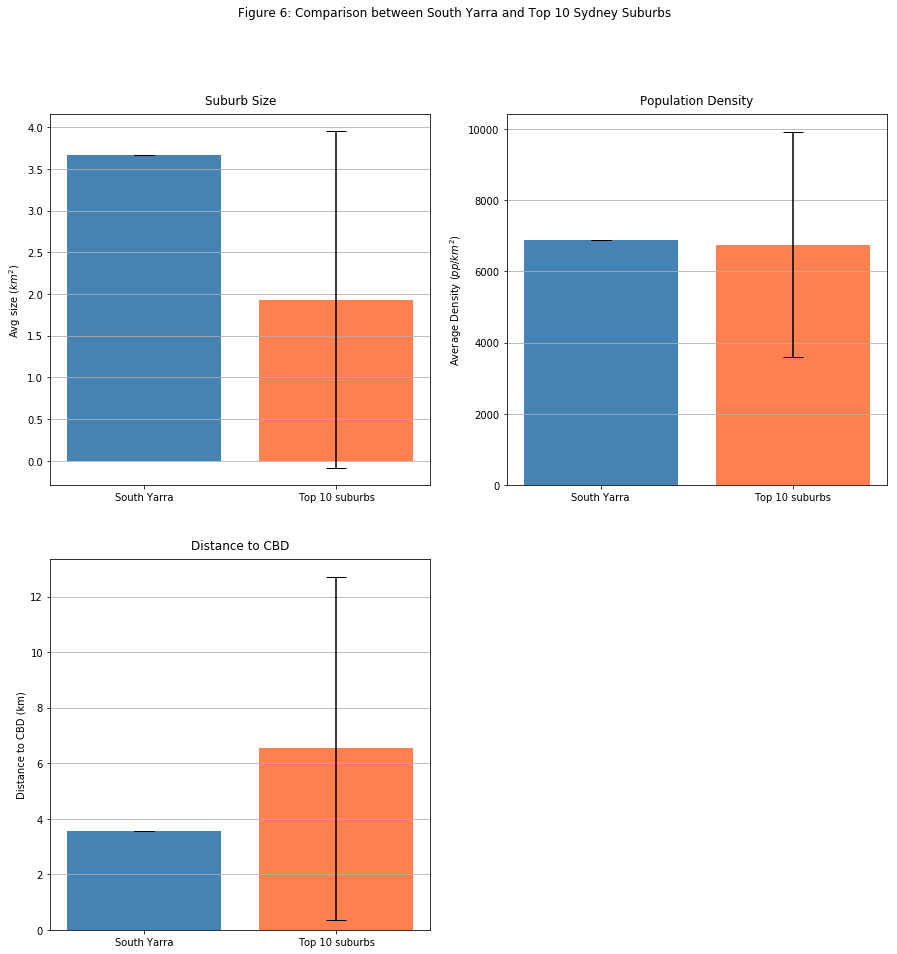

In [23]:
# Input data
input_index = aus_suburbs.loc[(aus_suburbs.Suburb == input_suburb['Suburb']) &
                              (aus_suburbs.City == input_suburb['City'])].index.values[0]
input_area = aus_suburbs.at[input_index, 'area']
input_density = aus_suburbs.at[input_index, 'density']
input_distance = aus_suburbs.at[input_index, 'distance']

# Get data from full suburb dataframe
top_geo = aus_suburbs.iloc[top_suburbs.Suburb_id.values]
top_geo = top_geo[['Suburb', 'Postcode', 'area', 'density', 'distance']]

# Calculate average
area_mean = np.mean(top_geo.area.values)
density_mean = np.mean(top_geo.density.values)
distance_mean = np.mean(top_geo.distance.values)

# Calculate standard deviation
area_std = np.std(top_geo.area.values)
density_std = np.std(top_geo.density.values)
distance_std = np.std(top_geo.distance.values)

# Subplot
# Create lists for the plot
input_mean = [input_area,
              input_density,
              input_distance]
mean_list = [area_mean,
             density_mean,
             distance_mean]
error_data = [area_std,
              density_std,
              distance_std]
chart_coordinates = [(0,0),
                     (0,1),
                     (1,0)]
y_labels = ['Avg size ($km^2$)',
            'Average Density ($pp/km^2$)',
            'Distance to CBD (km)']
titles = ['Suburb Size',
          'Population Density',
          'Distance to CBD']
category = [input_suburb['Suburb'],
            'Top {} suburbs'.format(top_n)]
x_pos = np.arange(len(category))

# Build the plot
fig, ax = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Figure 6: Comparison between South Yarra and Top 10 Sydney Suburbs')
for user_input, mean, error, coord, ylabel, title in zip(input_mean,
                                                         mean_list, 
                                                         error_data,
                                                         chart_coordinates,
                                                         y_labels,
                                                         titles):
    ax[coord].bar(x_pos,
                  [user_input, mean],
                  yerr=[0, error],
                  align='center',
                  alpha=1,
                  color=('steelblue', 'coral'),
                  capsize=10)
    ax[coord].set_ylabel(ylabel)
    ax[coord].set_xticks(x_pos)
    ax[coord].set_xticklabels(category)
    ax[coord].set_title(title, y=1.01)
    ax[coord].yaxis.grid(True)


# Delete empty axes
fig.delaxes(ax[1][1])
plt.show()

# Top 10 suburbs with their top local venues

In [24]:
# aus_suburbs.iloc[top_suburbs.Suburb_id.values]

top_ven = venues_sorted.iloc[top_suburbs.Suburb_id.values]
top_ven = top_ven.drop(['Suburb_id', 'LGA', 'City'], axis=1)

# top_ven = top_ven.reindex(top_suburbs_order)

# Add input suburb to compare its local venues
input_suburb_ven_sort = venues_sorted.loc[venues_sorted.Suburb == input_suburb['Suburb']]
input_suburb_ven_sort = input_suburb_ven_sort.drop(['Suburb_id', 'LGA', 'City'], axis=1)
top_ven_with_input = pd.concat([input_suburb_ven_sort, top_ven], ignore_index=True)

In [25]:
top_ven_with_input

,Suburb,Postcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,South Yarra,3141,Café,Italian Restaurant,Japanese Restaurant,Hotel,Convenience Store,Thai Restaurant,Bar,Grocery Store,Dessert Shop,French Restaurant
1,Woolwich,2110,Park,Bar,Italian Restaurant,Australian Restaurant,Café,Harbor / Marina,NaN,NaN,NaN,NaN
2,Parramatta,2150,Café,Thai Restaurant,Burger Joint,Chinese Restaurant,Mexican Restaurant,Dessert Shop,Juice Bar,Asian Restaurant,Japanese Restaurant,Italian Restaurant
3,Woolloomooloo,2011,Café,Italian Restaurant,Hotel,Australian Restaurant,Thai Restaurant,Hostel,Chinese Restaurant,Pub,Bar,Restaurant
4,Surry Hills,2010,Café,Pub,Pizza Place,Japanese Restaurant,Breakfast Spot,Lebanese Restaurant,Vietnamese Restaurant,Thai Restaurant,Karaoke Bar,Indian Restaurant
5,Crows Nest,2065,Café,Japanese Restaurant,Thai Restaurant,Vietnamese Restaurant,Italian Restaurant,Indian Restaurant,Bar,Sandwich Place,Mexican Restaurant,Asian Restaurant
6,Coogee,2034,Café,Hotel,Burger Joint,Bar,Park,Thai Restaurant,Fish & Chips Shop,Indian Restaurant,Italian Restaurant,Sushi Restaurant
7,The Rocks,2000,Café,Hotel,Australian Restaurant,Pub,Hotel Bar,Italian Restaurant,Steakhouse,Park,Cocktail Bar,Scenic Lookout
8,North Sydney,2060,Café,Gym,Japanese Restaurant,Bar,Juice Bar,Sandwich Place,Bakery,Vietnamese Restaurant,Plaza,Grocery Store
9,Neutral Bay,2089,Japanese Restaurant,Café,Thai Restaurant,Supermarket,Liquor Store,Bakery,Asian Restaurant,Pub,Spa,Mobile Phone Shop


Plot top suburbs venue frequencies onto bar chart

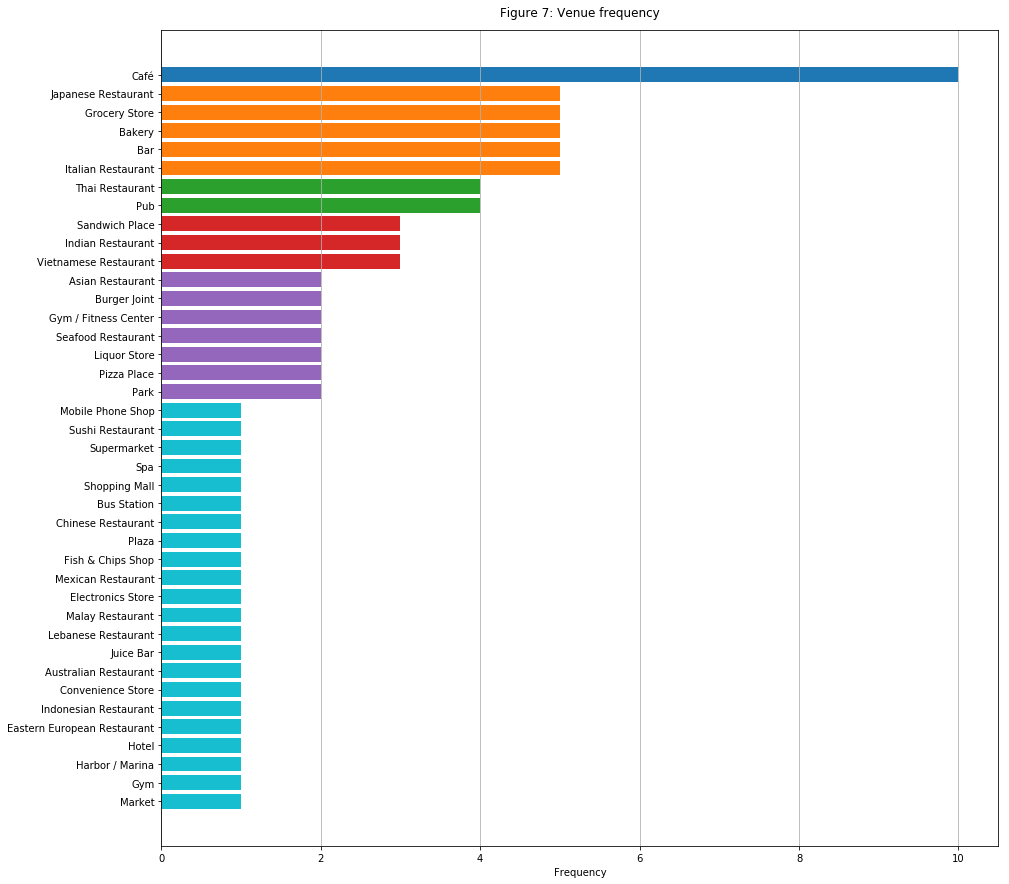

In [28]:
# List all of the venues in the dataframe
venues = top_ven.drop(['Suburb', 'Postcode'], axis=1)
venues = pd.DataFrame(data=venues.values.flatten())
venues = venues.dropna()
venues.rename(columns={0: "Venues"}, inplace=True)

# Group dataframe by venue and show its frequency count
venues_count = venues.groupby(['Venues']).agg({'Venues' :'count'})
venues_count.rename(columns={'Venues': 'Venues', 'Venues': 'Frequency'}, inplace=True)
venues_count.sort_values(by=['Frequency'], inplace=True, ascending=False)

# Create lists for the plot
materials = venues_count.index
y_pos = np.arange(len(materials))
values = venues_count.values.flatten()

unique_values = list(np.unique(values))
unique_values.sort(reverse=True)

bar_colours = ['tab:blue',
               'tab:orange',
               'tab:green',
               'tab:red',
               'tab:purple',
               'tab:cyan',
               'tab:brown',
               'tab:pink',
               'tab:gray',
               'tab:olive']
bar_colours_range = bar_colours[0:len(unique_values)]

# Build the plot
fig4 = plt.figure(figsize=(15,15))
for val, colour in zip(unique_values, bar_colours_range):
    mask = values == val
    plt.barh(y_pos[mask], values[mask], color=colour, align='center')
plt.xlabel('Frequency')
plt.yticks(y_pos, materials)
plt.title('Figure 7: Venue frequency', y=1.01)
plt.gca().invert_yaxis()
plt.grid(axis='x')

Some common venues among the top suburbs in relation to the input suburb (South Yarra, Melbourne) in descending order are:
* Cafe
* Japanese restuarant
* Pizza place
* Bar
* Italian restuarant
* Thai restaurant
* Bakery
* Park
* Gym
* Grocery Store

# Most similar suburbs on google maps

Get geographic data of top suburbs

In [29]:
top_ven_indexes = list(top_ven.index)
top_suburb_geo = aus_suburbs.iloc[top_ven_indexes]

Plot top suburbs onto a map

In [30]:
address = "Sydney, New South Wales"
geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Sydney, NSW are {}, {}.'.format(latitude, longitude))

GeocoderServiceError: [Errno 8] nodename nor servname provided, or not known

In [ ]:
# create map of Sydney using latitude and longitude values
map_sydney = folium.Map(location=[latitude, longitude], zoom_start=12)
# add markers to map
for lat, lng, suburb, postcode, lga in zip(top_suburb_geo['LAT'],
                                           top_suburb_geo['LON'],
                                           top_suburb_geo['Suburb'],
                                           top_suburb_geo['Postcode'],
                                           top_suburb_geo['LGA']):
    #print(lat, lng)
    label = '{}, {}, {}'.format(suburb, postcode, lga)
    label = folium.Popup(label, parse_html=True)

    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sydney)  
    
map_sydney

# Discussion and conclusions

The aim of this project was to develop a content-based recommendation system to return a list of suburbs from a city that are similar to the user's ideal suburb. The attributes that were used to measure the degree of similarty were suburb size, the suburb's distance to the cbd, population density, and the top local venues.

KNN
A KNN (kth Nearest Neighbour) coupled with pairwise euclidean distance measurement was used to find the most similar suburbs in regards to size, distance, and density. KNN was an appropriate choice because of the low dimensionality (3-dimensions) and high density of the data. Before measuring the nearest neighbour distances, a PCA analysis was performed to reduce the dimensionality of the data. PCA results show that PC1 accounts for almost 75% of the total variation of principle components while PC2 accounts for almost 15% (Figure 1). Together these two axis would account for the vast majority of the  variation of the data and would be a good approximation of a three dimensional graph (Figure 2).

Afterwards, KNN distances were calculated from the PCA transformed data (Figure 3). The distances were inversed and normalised to show the degree of similarity where values close to 1 suggested that those suburbs were most similar and values closer to 0 were less similar. The results show that the suburbs that were most similar in Sydney to South Yarra are the following:

|Suburb         | KNN normalised |
|---------------|----------------|
|Woolwich       |0.99            |
|Kensington     |0.22            |
|Believue Hill  |0.22            |
|Greenwich      |0.21            |
|Leichhardt     |0.15            |
|Rozelle        |0.13            |
|Lilyfield      |0.12            |
|Longueville    |0.12            |
|Drummoyne      |0.12            |
|Cammeray       |0.11            |

The area, density, and distance values from the recommended suburbs were then plotted as bar charts and compared with the input suburb (South Yarra) (Figure 4). Here we see that although the population density and distance to the cbd for South Yarra are within approximation of the top 10 most similar suburbs from Sydney, the South Yarra suburb size is significantly larger than the listed suburbs from Sydney, however this could be expected since Sydney's geography is denser than Melbourne. From the results, we see that Kensington is the most similar suburb followed by Leichhardt and Randwick. The specificity of the results can be further improved by including local demographic data.

Dot Product
To quantify the degree of similarity in regards to top venues, the dot product was calculated between the user input's suburb venue array and sydney suburb's venue matrix. Here the dot product value was then normalised between 1 and 0, where 1 indicates there are more common features between the input suburb (South Yarra) and the destination suburb (Sydney suburb). The results show that the most similar suburb in regards to local venues alone include Parramatta, Woolomoollo, and Crows nest.

|Suburb         | Dot product normalised |
|---------------|------------------------|
|Parramatta     |1.00                    |
|Woolloomoolo   |0.89                    |
|Crows Nest     |0.76                    |
|Surry Hills    |0.66                    |
|The Rocks      |0.64                    |
|Darlinghurst   |0.59                    |
|Glebe          |0.55                    |
|Bankstown      |0.54                    |
|Chippendale    |0.54                    |
|Coogee         |0.53                    |

One thing that should be taken into account is the availability of data for the local venues. Since the dot product relies on the sum of products between aligned attributes, missing local venues can significantly lower the final dot product score. Also, data wrangling with the local venue categories can further improve the results by grouping together similar categories such as 'coffee shop' and 'cafe'.

KNN and Dot product combined
An attempt to list similar suburbs by considering all the attributes (suburb size, population density, distance to cbd, and local venues) was implemented by finding the average score betweeen the KNN normalised value and the dot product normalised value and ranking them in descending order. The following suburbs were listed:

|Suburb       |KNN normalised|dot product normalised|Final score|
|-------------|--------------|----------------------|-----------|
|Leichhardt   |0.15          |0.49                  |0.07       |
|North Sydney |0.09          |0.45                  |0.04       |
|Woolwich     |0.99          |0.04                  |0.04       |
|Kensington   |0.22          |0.16                  |0.04       |
|Glebe        |0.05          |0.65                  |0.03       |
|Crows Nest   |0.04          |0.77                  |0.03       |
|Lilyfield    |0.12          |0.21                  |0.03       |
|Coogee       |0.04          |0.59                  |0.02       |
|Greenwich    |0.22          |0.10                  |0.02       |
|Cammeray     |0.11          |0.19                  |0.02       |

Here we see that suburbs such as Crows Nest and Coogee have very low KNN scores which suggests that these suburbs are not very similar to the input suburb (South Yarra) in regards to either suburb size, distance to cbd, or population density. While at the same time, the suburbs have a significantly higher dot product scores which means that these suburbs are similar to South Yarra in regards to their local venues. This can be overcome by applying a threshold where suburbs that are too different in either category can are automatically removed from the list. However, determining this threshold quantitatively is a non-trivial task.